In [1]:
#imports
from numpy import *
from time import sleep
from numpy.matrixlib.defmatrix import matrix
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

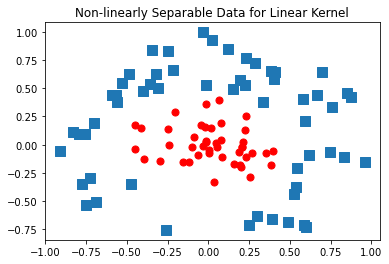

In [2]:
#plot data points
fig = plt.figure()
ax = fig.add_subplot(111)
xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []

fr = open('trainSetRBF.txt')
for line in fr.readlines():
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(float(lineSplit[2]))
    if (label == -1):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)
ax.scatter(xcord0, ycord0, marker='s', s=90)
ax.scatter(xcord1, ycord1, marker='o', s=50, c='red')
plt.title('Non-linearly Separable Data for Linear Kernel')
plt.show()
fr.close()

In [3]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat


def selectJrand(i, m):
    j = i  # we want to select any J not equal to i
    while (j == i):
        j = int(random.uniform(0, m))
    return j


def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

def kernelTrans(X, A, kernel):  # calc the kernel or transform data to a higher dimensional space
    m, n = shape(X)
    K = mat(zeros((m, 1)))
    if kernel[0] == 'lin':
        K = X * A.T  # linear kernel
    elif kernel[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow*deltaRow.T
        # divide in NumPy is element-wise not matrix like Matlab
        K = exp(K/(-1*kernel[1]**2))
    else:
        raise NameError('Kernel is not recognized')
    return K

In [4]:
class SVM:
    # Initialize the structure with the parameters
    def __init__(self, kernel=('lin', 0), C=200, toler=0.0001, max_iter=100):
        self.C = C
        self.tol = toler
        self.b = 0
        self.max_iter = max_iter
        self.kernel = kernel

        # for prediction
        self.sVs = None
        self.labelSV = None
        self.svInd = None

    def fit(self, dataMatIn, classLabels):
        self.X = mat(dataMatIn)
        self.labelMat = mat(classLabels).transpose()
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.K = mat(zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], self.kernel)
        self.smo()
        self.svInd = nonzero(self.alphas.A > 0)[0]
        self.sVs = self.X[self.svInd]  # get matrix of only support vectors
        self.labelSV = self.labelMat[self.svInd]
        return self

    def calcEk(self, k):
        fXk = float(multiply(self.alphas, self.labelMat).T *
                    self.K[:, k] + self.b)
        Ek = fXk - float(self.labelMat[k])
        return Ek

    def innerL(self, i):
        Ei = self.calcEk(i)
        if ((self.labelMat[i]*Ei < -self.tol) and (self.alphas[i] < self.C)) or ((self.labelMat[i]*Ei > self.tol) and (self.alphas[i] > 0)):
            j = selectJrand(i, self.m)
            Ej = self.calcEk(j)
            alphaIold = self.alphas[i].copy()
            alphaJold = self.alphas[j].copy()
            if (self.labelMat[i] != self.labelMat[j]):
                L = max(0, self.alphas[j] - self.alphas[i])
                H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
            else:
                L = max(0, self.alphas[j] + self.alphas[i] - self.C)
                H = min(self.C, self.alphas[j] + self.alphas[i])
            if L == H:
                # print("L==H")
                return 0
            eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
            if eta >= 0:
                # print("eta>=0")
                return 0
            self.alphas[j] -= self.labelMat[j]*(Ei - Ej)/eta
            self.alphas[j] = clipAlpha(self.alphas[j], H, L)
            if (abs(self.alphas[j] - alphaJold) < 0.00001):
                # print("j not moving enough")
                return 0
            self.alphas[i] += self.labelMat[j] * \
                self.labelMat[i] * (alphaJold - self.alphas[j])
            b1 = self.b - Ei - self.labelMat[i]*(self.alphas[i]-alphaIold) * \
                self.K[i, i] - self.labelMat[j] * \
                (self.alphas[j]-alphaJold)*self.K[i, j]
            b2 = self.b - Ej - self.labelMat[i]*(self.alphas[i]-alphaIold) * \
                self.K[i, j] - self.labelMat[j] * \
                (self.alphas[j]-alphaJold)*self.K[j, j]
            if (0 < self.alphas[i]) and (self.C > self.alphas[i]):
                self.b = b1
            elif (0 < self.alphas[j]) and (self.C > self.alphas[j]):
                self.b = b2
            else:
                self.b = (b1 + b2)/2.0
            return 1
        else:
            return 0

    def smo(self):
        current_iter = 0
        alphaPairsChanged = 0
        while (current_iter < self.max_iter):
            alphaPairsChanged = 0
            for i in range(self.m):
                alphaPairsChanged += self.innerL(i)
                # print(
                #     f"fullSet, current_iter: {current_iter} i:{i}, pairs changed {alphaPairsChanged}")
            current_iter += 1 if alphaPairsChanged > 0 else 0
            # print(f"current_iteration number: {current_iter}")
        return self

    def accuracy(self, test_data=None, test_label=None):
        errorCount = 0
        (X, labelMat) = (mat(test_data), mat(test_label).transpose()) if (
            test_data and test_label) else (self.X, self.labelMat)
        for i in range(self.m):
            kernelEval = kernelTrans(self.sVs, X[i, :], self.kernel)
            predict = kernelEval.T * \
                multiply(self.labelSV, self.alphas[self.svInd]) + self.b
            if sign(predict) != sign(labelMat[i]):
                errorCount += 1
        return ((1-(errorCount)/self.m)*100)

In [5]:
# using linear kernel
dataArr, labelArr = loadDataSet('trainSetRBF.txt')
svm = SVM()
accuracy = svm.fit(dataArr, labelArr).accuracy()
print(f"Linear Kernel: \nTraining accuracy is: {accuracy}%")
dataArr, labelArr = loadDataSet('testSetRBF.txt')
accuracy = svm.accuracy(dataArr, labelArr)
print(f"Test accuracy is: {accuracy}%")

# using rbf kernel
svm.kernel = ('rbf', 1.3)
accuracy = svm.fit(dataArr, labelArr).accuracy()
print(f"RBF Kernel: \nTraining accuracy is: {accuracy}%")
dataArr, labelArr = loadDataSet('testSetRBF.txt')
accuracy = svm.accuracy(dataArr, labelArr)
print(f"Test accuracy is: {accuracy}%")

Linear Kernel: 
Training accuracy is: 56.00000000000001%
Test accuracy is: 51.0%
RBF Kernel: 
Training accuracy is: 94.0%
Test accuracy is: 94.0%
